In [96]:
import numpy as np
from random import randint

# 1. Смит-Ватерман

Считывем из файла таблицу весов PAM250

In [269]:
W = np.empty((25,25), dtype=np.int)
ind = {}

f = open('PAM_250.txt', 'r')
amino = f.readline().split()[1:]
ind = {amino[i]:i for i in range(25)}
for i in range(25):
    W[i,:] = np.array(f.readline().split()[2:])
    
f.close()

Или берем стандартные match = 1, mismatch = -1, gap = -1

In [227]:
W = np.diag(np.ones(25, dtype=np.int)*2) - np.ones((25,25), dtype=np.int)

Создаем независимо мутировавшие аминокислотные последовательности 

In [116]:
def mutogenesis(s, num, max_len):
    for _ in range(num):
        pos = randint(0, len(s)-1)
        ins = randint(1,max_len)
        dlt = randint(1,max_len)
        s = s[:pos] + ''.join([amino[randint(0, 19)] for _ in range(ins)]) + s[pos+dlt:]
    return s

In [248]:
a = ''.join([amino[randint(0, 19)] for _ in range(50)])
b = a
a = mutogenesis(a, 10, 3)
b = mutogenesis(b, 10, 3)
print(a)
print(b)

HLAITNGHYCSQQVGHYEVQQAGQVSVGDENFVSPPCRMIIAIEPENIAMYCE
VQQWEAMFFWGSYCSQQVGHYLVQQAGNETDKGDEHTWPDEVMIKSRSPRGAMISS


## Выравниваем

In [208]:
def gap_w(s):
    w = np.zeros((len(s)+1))
    for i in range(1, len(s)+1):
        w[i] = w[i-1] + W[ind[s[i-1]], ind['-']]
    return w

In [249]:
n, m = len(a), len(b)

D = np.empty((n+1, m+1), dtype=np.int)
D[:,0] = gap_w(a)
D[0,:] = gap_w(b)

In [250]:
n, m = len(a), len(b)

D = np.zeros((n+1, m+1), dtype=np.int)

In [251]:
for i in range(1, n+1):
    for j in range(1, m+1):
        a_gap = D[i, j-1] + W[ind[b[j-1]], ind['-']]
        b_gap = D[i-1, j] + W[ind[a[i-1]], ind['-']]
        match = D[i-1, j-1] + W[ind[a[i-1]], ind[b[j-1]]]
        D[i, j] = max(a_gap, b_gap, match, 0)

Восстанавливаем выравнивания

In [212]:
def argmax(arr):
    s = np.shape(arr)
    am = arr.argmax()
    ind = []
    i = 0
    for d in s:
        i += 1
        if len(s[i:]):
            c = np.product(s[i:])
        else:
            c = 1
        ind.append(am // c)
        am %= c
    return tuple(ind)

In [252]:
i, j = argmax(D)
a1, b1, mtc = a[i:][::-1], b[j:][::-1], ''

while D[i, j] != 0:
    if D[i, j] == D[i-1, j] + W[ind[a[i-1]], ind['-']]:
        a1 += a[i-1]
        b1 += '-'
        mtc += ' '
        i -= 1
    elif D[i, j] == D[i, j-1] + W[ind[b[j-1]], ind['-']]:
        a1 += '-'
        b1 += b[j-1]
        mtc += ' '
        j -= 1
    else:
        a1 += a[i-1]
        b1 += b[j-1]
        if a[i-1] == b[j-1]:
            mtc += '|'
        else:
            mtc += ' '
        i -= 1
        j -= 1
        
a1 += a[:i][::-1]
b1 += b[:j][::-1]
if i > j:
    d = i - j
    b1 += ' '*d
    mtc += ' '*i
else:
    d = j - i
    a1 += ' '*d
    mtc += ' '*j  

In [253]:
print(a1[::-1])
print(mtc[::-1])
print(b1[::-1])

    HLAITNGHYCSQQVGHYEVQQAGQVSVGDENFVSPPCRMIIAIEPENIAMYCE
            ||||||||| |||||
VQQWEAMFFWGSYCSQQVGHYLVQQAGNETDKGDEHTWPDEVMIKSRSPRGAMISS


### Тест

In [ ]:
a = 'TCCCAGTTATGTCAGGGGACACGAGCATGCAGAGAC'
b = 'AATTGCCGCCGTCGTTTTCAGCAGTTATGTCAGATC'

In [215]:
print(a1[::-1])
print(mtc[::-1])
print(b1[::-1])

                  TCCCAGTTATGTCAGGGGACACGAGCATGCAGAGAC
                     ||||||||||||
AATTGCCGCCGTCGTTTTCAGCAGTTATGTCAGATC


Локальное выравнивание с единичными весами

In [226]:
print(a1[::-1])
print(mtc[::-1])
print(b1[::-1])

T--CC-CAGT--TATGTCAGAGGGCACGAGCATG-CAGAGAC
|  || | ||  | | ||||    || |   ||| ||||  |
TGTCCGCCGTGCTTT-TCAG----CA-GTT-ATGTCAGAT-C


Глобальное выравнивание с единичными весами

# 2. Афинные гэпы

In [220]:
diff = lambda a, b : int(a == b)*2 - 1
p, d = 0, 1

In [259]:
a = 'TCCCAGTTATGTCAGGGGACACGAGCATGCAGAGAC'
b = 'AATTGCCGCCGTCGTTTTCAGCAGTTATGTCAGATC'

## Выравниваем

In [265]:
n, m = len(a), len(b)

D = np.empty((n+1, m+1))
D[:,0] = -(p + np.arange(len(a)+1)*d)
D[0,:] = -(p + np.arange(len(b)+1)*d)
D[0,0] = 0

In [266]:
for i in range(1, n+1):
    for j in range(1, m+1):
        a_gap = max(D[i,:j] - (p + np.arange(1,j+1)*d)[::-1])
        b_gap = max(D[:i,j] - (p + np.arange(1,i+1)*d)[::-1])
        match = D[i-1, j-1] + diff(a[i-1], b[j-1])
        D[i, j] = max(a_gap, b_gap, match)

Восстанавливаем выравнивания

In [267]:
i, j = n, m
a1, b1, mtc = '', '', ''

while i > 0 and j > 0:
    if D[i, j] == max(D[:i,j] - (p + np.arange(1,i+1)*d)[::-1]):
        ami = np.argmax(D[:i,j] - (p + np.arange(1,i+1)*d)[::-1])
        a1 += a[ami:i]
        b1 += '-' * (i-ami)
        mtc += ' ' * (i-ami)
        i = ami
    elif D[i, j] == max(D[i,:j] - (p + np.arange(1,j+1)*d)[::-1]):
        amj = np.argmax(D[i,:j] - (p + np.arange(1,j+1)*d)[::-1])
        a1 += '-' * (j-amj)
        b1 += b[amj:j]
        mtc += ' ' * (j-amj)
        j = amj
    else:
        a1 += a[i-1]
        b1 += b[j-1]
        if a[i-1] == b[j-1]:
            mtc += '|'
        else:
            mtc += ' '
        i -= 1
        j -= 1

### Тест 1

In [ ]:
p, d = 0, 1

In [225]:
print(a1[::-1])
print(mtc[::-1])
print(b1[::-1])

T--CC-CAGT--TATGTCAGAGGGCACGAGCATG-CAGAGAC
|  || | ||  | | ||||    || |   ||| ||||  |
TGTCCGCCGTGCTTT-TCAG----CA-GTT-ATGTCAGAT-C


### Тест 2

In [254]:
p, d = 100, 0.01

In [263]:
print(a1[::-1])
print(mtc[::-1])
print(b1[::-1])

TCCCAGTTATGTCAGGGGACACGAGCATGCAGAGAC
          |||        |    |||      |
AATTGCCGCCGTCGTTTTCAGCAGTTATGTCAGATC


### Тест 3

In [264]:
p, d = -0.5, 0.3

In [268]:
print(a1[::-1])
print(mtc[::-1])
print(b1[::-1])

T--CC-C-AGT--TATGT-CAGGGGACACG--A-GCATGCAGA-GAC
|  || |  ||  | | | |||    || |  | |  | ||||   |
TTGCCGCC-GTCGT-T-TTCAG----CA-GTTATG--T-CAGAT--C


# 3. Blastn

In [278]:
s_100    = ''.join([['A', 'T', 'G', 'C'][randint(0, 3)] for _ in range(100)])
s_1000   = ''.join([['A', 'T', 'G', 'C'][randint(0, 3)] for _ in range(1000)])
s_100000 = ''.join([['A', 'T', 'G', 'C'][randint(0, 3)] for _ in range(100000)])

In [279]:
print(s_100)

CGCCGATAGCCGCTCCATACACCTTAACCAGAGGACCAGGTACGTAGACTGTGGCTTGCTCGACTGTTTGCTGGTCATGTGGCTACGCCTCTCGTGTGAT


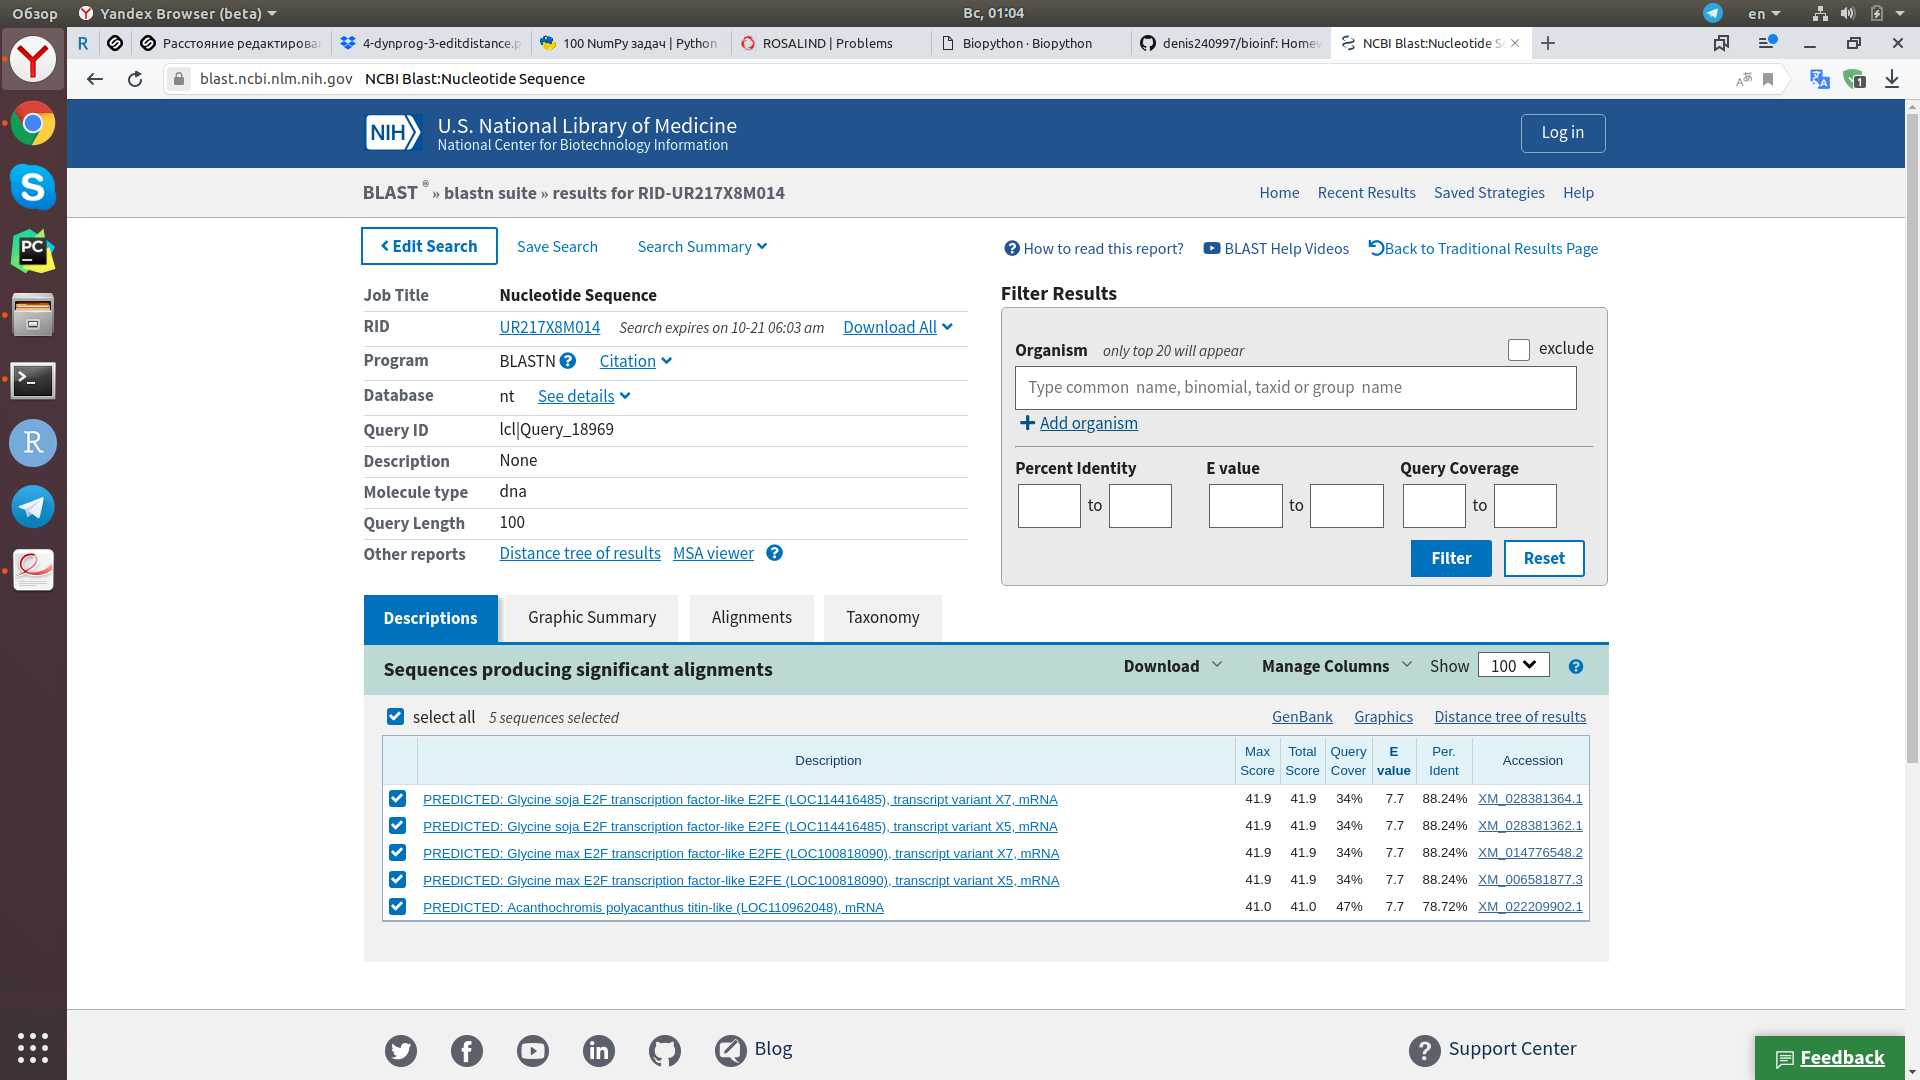

In [280]:
print(s_1000)

CAAAGTCTTAGGACACGTAGACCTCCGCTGCAGTGTTACGATAGACGCAGGTGAAAGCCAAAGCCCAGAATGTTCAAGGCACGTATTTCCTCGCGATCGCTCCTCAATTAATGGTACTTAATGTCATAGAGCGGATCCCTGGTCAAAATATATCCTTAGGCTTCAGCAGCTCCACCATACCCGGCGAGGGCATCGTCTTGGCTATACAGACTCAGCCTAATTGGAGTGTTCTATGGTTGATGGGCCGTCCACGTTACATCCCAGGGTGGTTCGTGAGCATAGAGCCAAAGGACATTCGGGGTCTTGGTGTCTCATCGTCCACAGGGGTGGGACCCAGAATGGCTGGTCTCTGCCCTAAGACTTCGTGCCTGGTATATGCATGCGATATAGCCAACGTAATTCAGGATTGCTTCACTGCGAGTAAAATACGCTGCTGTCTTGTCCAGCGGTTCCTGCGTTCTGGTGTGCACTTAAGATGCACAAGGAAGTATACAGCAAGTGACACCAACTCTGCTGTATAGATTGCATCAGAGGCGGAGAGACGCCAGAACGGCTTGTGCCTGAGGTCCGGCTACAAGGTTCGGTCCTACAGAGTATCGATAAAACAGTGAGGCGGGAGTGGTAAACTGAAGAAACTATACAATGTACTTACAGTCGGGTTGTCCACATCGTACATTAGGGGATGACCGGAGCATTTTTTAGAGTAGGAGAGATACGGTAAACTCCACATTATTGCCTAACAAGTCAAGCACCGTAACTCTCACTCGGCACAGACCCGTGGATTCCTAATAACGACTTCCGAATTGCCTCACGTCGATACAAGTACAGATTCGGCTAGCACGCTGGTAATATGCGGTTATTGGCTCGCCACAATTCGACCATTTGGTGTATGACATAGTTCGAGCGGCCTTACCCTGCGCATTTATACCCCCCTCGCATCATCAAACCGGACTAGATCGCAAAGCAGCTCGAGCGAATACTAGGCGGAAAGCCGATCTGT

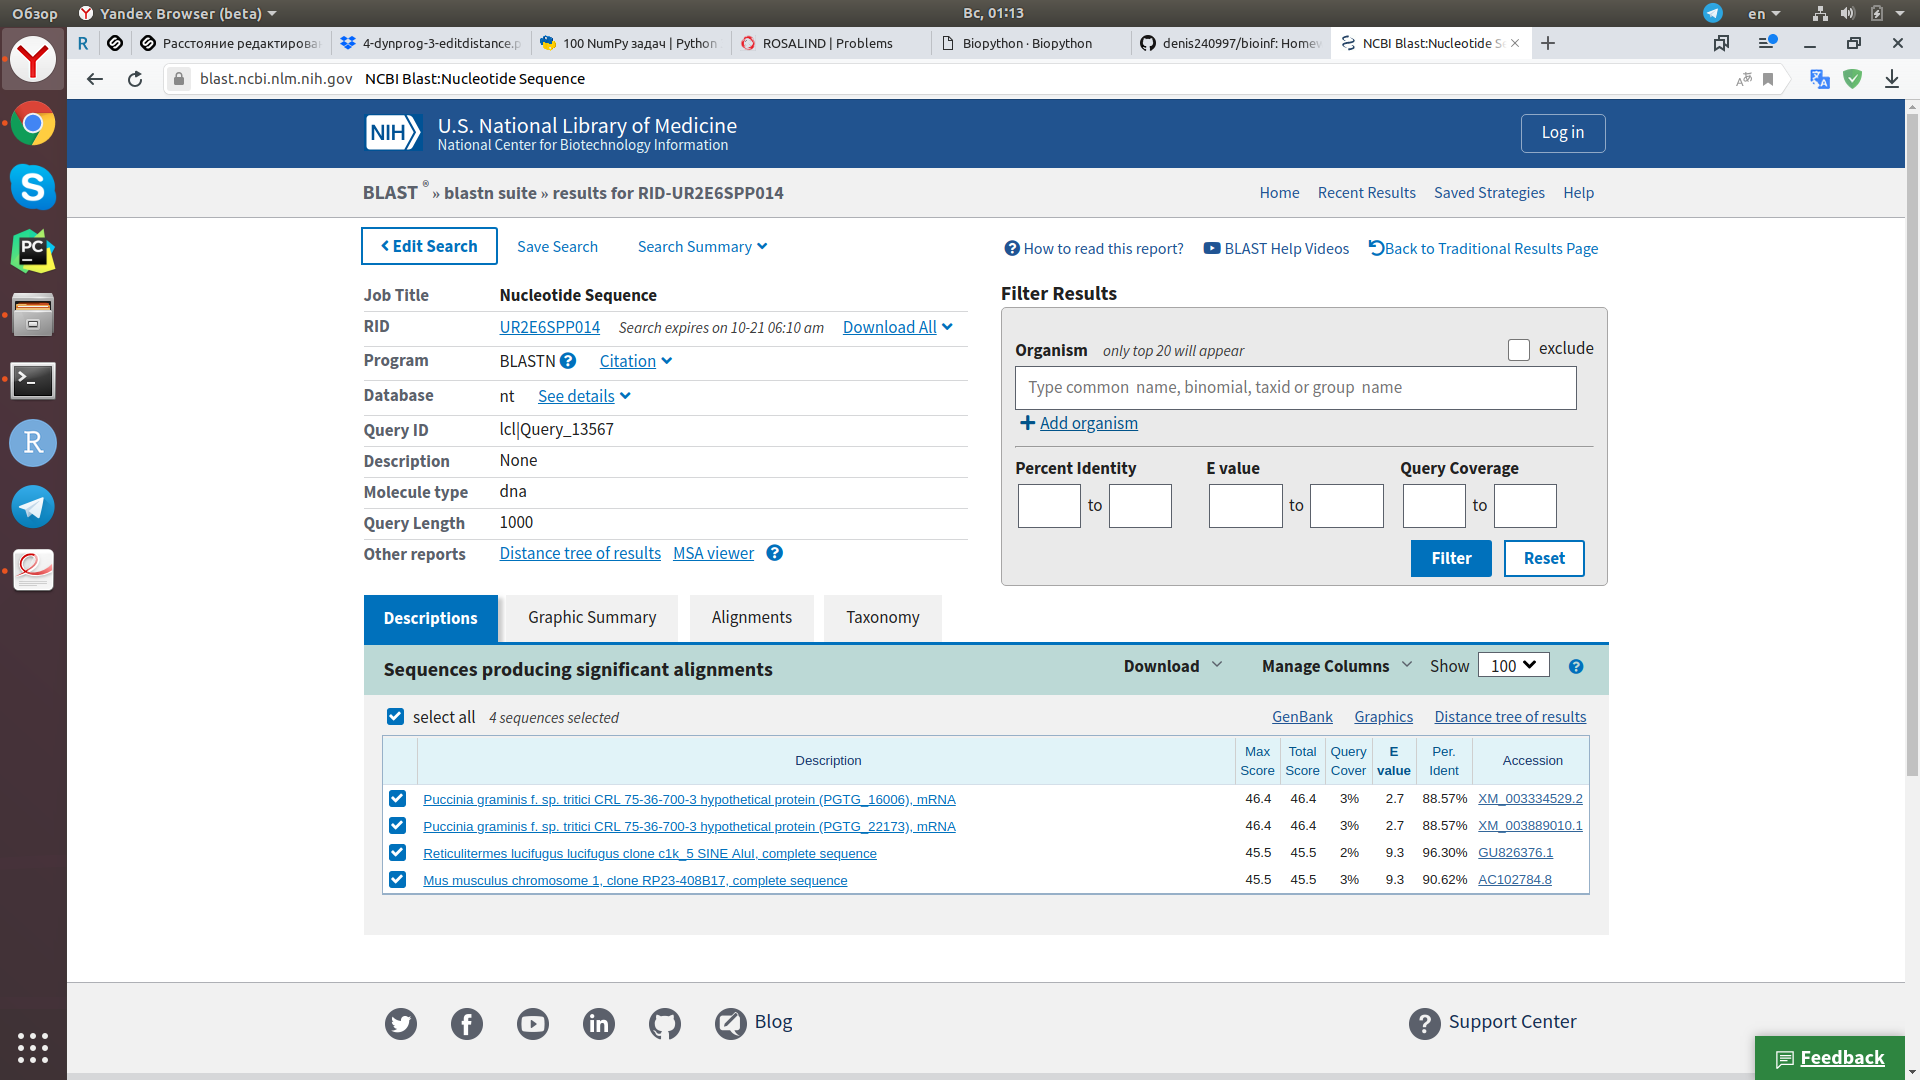

In [281]:
print(s_100000)

AGCTCCACATACCATAGTTTGCGGCAAAGCCCGTCGCCGTATCTAAGTAGCTAGCCGACCGATAGGCCAGTAATCGCAGGCGCCATCGAGTGATATCAGATATTCTAGCAGTGCGTGAAAGACCCGGCTACGGTTCATGGCCGCCATGGTCGGGCTCGCCACTCTTTAGCGGCACTGCGGGGTTCTTAAGGGACCCCTACTCAGGGGCAAAGACTCGACCCGAGGCTTAGGGTCTTCCCAACGGAACTGTCTTCGCGCCCATCTATGGTTGGCTACGCATATAGGAGTTTAGTTCCTTTCGCGCGTACTAAGACGAAACAGACGCTATGCTTCAAATGCGGCGTGCGACCCTACAACTAGCTACACGCGTGAAACCCCCGGGCCTAGCCCCGTTCGTGTCGAGTCCGGTATAGGGAGTTGTTGCGATGAAGTGTAACGACGGGACCCTCATGACGCTTATAAGGCGCACTGGAGTGGATGAATTGCCTCTTACGTACAACAGCGCCTCTCTGCACCACTGGAAGCTTTGTTAAGCGTCATAACCCACATGCGACAAATTGTCCCGGGGATTGATCTTTATAAAATTAGACCTAAGCTCGAGGCGCGTTGTACGAAGCGACCCAACGATGTAACGCTCCAGTTGCGTCTACCACCGAACCACGGTCCATCCCATAAGACCGCTAGCGAGCTATGAACAGCACATATCAGAGACGGGTGCGAATAGTCAACGGGTCTGCCGGGCGTGCTCTGCCTTTACCGTGGTCTGTTCAAGGACCGGATCATGTGAAATCAAAGTAGACCTTTTAACGGGCTTGAACTAGGCGCCTTGCGCCTACCATAGCTAACAGAAGTACTCCTAGCCGTTGTAACGTGTTCCCACAAAAACTTATAAACGTTTTGGAGACTATTTGTGAAACTATTTGTTATTACAGTGGTTTCAGAAGCGTTAACATAGGCCTGCTGATGACAGTGATACAACAGACGTGATTCATAGGAAACA

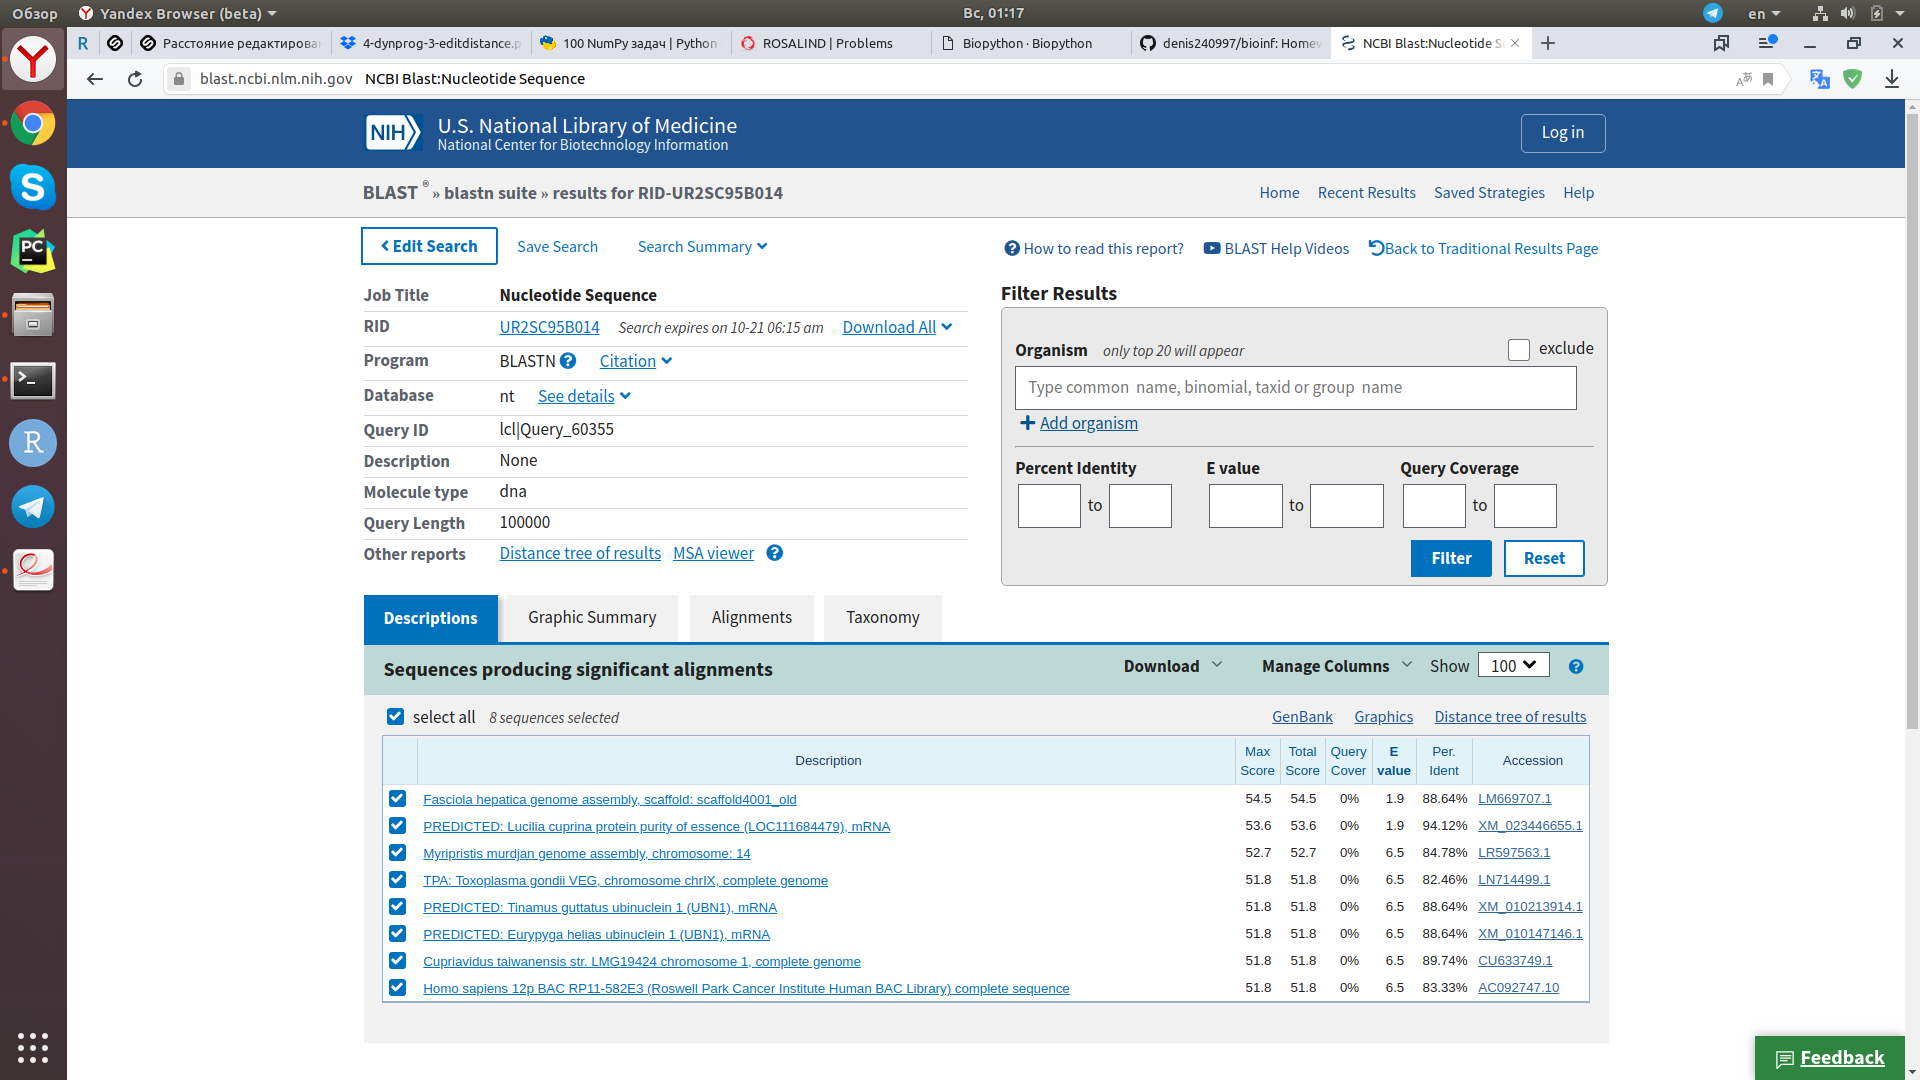